Wavenet pytorch version
herit from @ragnar123 notebook https://www.kaggle.com/ragnar123/wavenet-with-1-more-feature
and @brandenkmurray notebook https://www.kaggle.com/brandenkmurray/seq2seq-rnn-with-gru
I just add wavenet with pytorch version
hope this notebook will help 



V4 change wavenet from sequential model to multi layer feature parallel, thanks @cdeotte point out the difference that my old verson with keras wavenet in other kernel, which has more good result.  [detail info](https://www.kaggle.com/c/liverpool-ion-switching/discussion/145256)



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
#from tqdm import tqdm
from tqdm.notebook import tqdm
import gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

import os
# for dirname, _, filenames in os.walk('../input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# configurations and main hyperparammeters
EPOCHS = 150
NNBATCHSIZE = 16
GROUP_BATCH_SIZE = 4000
SEED = 321
LR = 0.001
SPLITS = 5

outdir = 'wavenet_models'
flip = False
noise = False


if not os.path.exists(outdir):
    os.makedirs(outdir)



def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [2]:
# read data
def read_data():
    train = pd.read_csv('../input/train_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv('../input/test_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32})
    sub  = pd.read_csv('../input/sample_submission.csv', dtype={'time': np.float32})
    return train, test, sub

# create batches of 4000 observations
def batching(df, batch_size):
    #print(df)
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test

# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df, batch_size):
    # create batches
    df = batching(df, batch_size = batch_size)
    # create leads and lags (1, 2, 3 making them 6 features)
    df = lag_with_pct_change(df, [1, 2, 3])
    # create signal ** 2 (this is the new feature)
    df['signal_2'] = df['signal'] ** 2
    return df

# fillna with the mean and select features for training
def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'group', 'open_channels', 'time']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features


def split(GROUP_BATCH_SIZE=4000, SPLITS=5):
    print('Reading Data Started...')
    train, test, sample_submission = read_data()
    train, test = normalize(train, test)
    print('Reading and Normalizing Data Completed')
    print('Creating Features')
    print('Feature Engineering Started...')
    train = run_feat_engineering(train, batch_size=GROUP_BATCH_SIZE)
    test = run_feat_engineering(test, batch_size=GROUP_BATCH_SIZE)
    train, test, features = feature_selection(train, test)
    print(train.head())
    print('Feature Engineering Completed...')

    target = ['open_channels']
    group = train['group']
    kf = GroupKFold(n_splits=SPLITS)
    splits = [x for x in kf.split(train, train[target], group)]
    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[1])
        new_splits.append(new_split)
    target_cols = ['open_channels']
    print(train.head(), train.shape)
    train_tr = np.array(list(train.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
    train = np.array(list(train.groupby('group').apply(lambda x: x[features].values)))
    test = np.array(list(test.groupby('group').apply(lambda x: x[features].values)))
    print(train.shape, test.shape, train_tr.shape)
    return train, test, train_tr, new_splits


In [3]:
train, test, sample_submission = read_data()
train, test = normalize(train, test)

# train = run_feat_engineering(train, batch_size=GROUP_BATCH_SIZE)
# test = run_feat_engineering(test, batch_size=GROUP_BATCH_SIZE)
# train, test, features = feature_selection(train, test)

# target = ['open_channels']
# group = train['group']

In [6]:
import matplotlib.pyplot as plt

In [9]:
a = train.groupby(train.index//4000, sort=False)['signal'].agg(['ngroup']).values

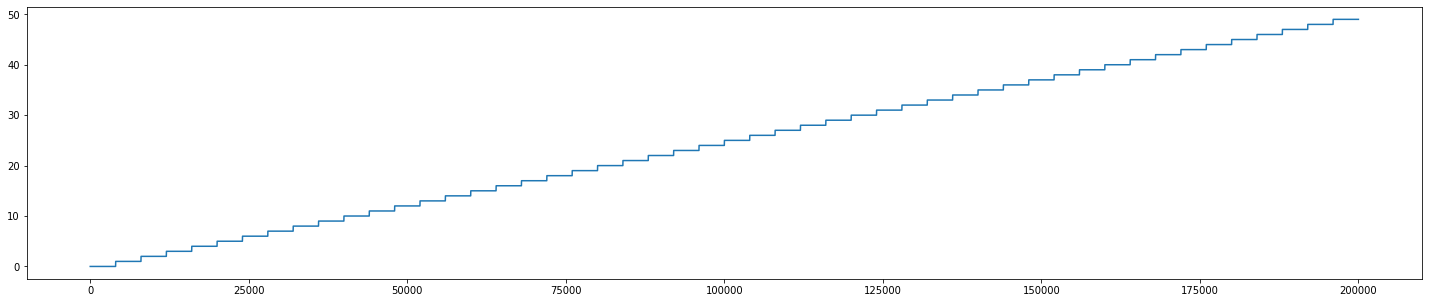

In [14]:
_, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(a[:200000])

In [8]:
kf = GroupKFold(n_splits=SPLITS)
splits = [x for x in kf.split(train, train[target], group)]

In [13]:
train_gb = np.array(list(train.groupby('group').apply(lambda x: x[features].values)))

In [14]:
train_gb.shape

(1250, 4000, 8)

In [12]:
np.unique(group[splits[0][0]])

array([   0,    1,    3,    4,    5,    6,    8,    9,   10,   11,   13,
         14,   15,   16,   17,   18,   20,   22,   23,   24,   25,   27,
         28,   29,   30,   32,   33,   34,   35,   36,   37,   39,   40,
         41,   43,   44,   45,   46,   48,   49,   50,   51,   53,   54,
         55,   56,   58,   59,   60,   62,   63,   64,   65,   66,   68,
         69,   70,   72,   73,   74,   75,   76,   77,   80,   81,   82,
         83,   85,   86,   87,   88,   90,   91,   92,   93,   95,   96,
         97,   98,  100,  101,  102,  103,  105,  106,  107,  108,  110,
        111,  112,  113,  115,  116,  117,  118,  120,  121,  122,  123,
        125,  126,  127,  128,  130,  131,  132,  133,  134,  135,  136,
        137,  139,  140,  141,  142,  144,  145,  146,  147,  149,  150,
        151,  152,  154,  155,  157,  159,  160,  161,  162,  164,  165,
        166,  167,  169,  170,  171,  172,  173,  174,  175,  176,  178,
        179,  180,  181,  183,  184,  185,  186,  1

In [8]:
kf = GroupKFold(n_splits=SPLITS)

In [14]:
splits = [x for x in kf.split(np.arange(50), np.arange(50), np.concatenate([np.ones(10) * i for i in range(5)]))]

In [21]:
splits[4]

(array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

change wavenet model, this code is from [Understanding Ion-Switching with modeling](https://www.kaggle.com/mobassir/understanding-ion-switching-with-modeling)  and also change a little

In [4]:
# wavenet 
# from https://www.kaggle.com/hanjoonchoe/wavenet-lstm-pytorch-ignite-ver
class Wave_Block(nn.Module):

    def __init__(self, in_channels, out_channels, dilation_rates, kernel_size):
        super(Wave_Block, self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()

        self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=1))
        dilation_rates = [2 ** i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            self.filter_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.gate_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1))

    def forward(self, x):
        x = self.convs[0](x)
        res = x
        for i in range(self.num_rates):
            x = torch.tanh(self.filter_convs[i](x)) * torch.sigmoid(self.gate_convs[i](x))
            x = self.convs[i + 1](x)
            res = res + x
        return res
# detail 
class Classifier(nn.Module):
    def __init__(self, inch=8, kernel_size=3):
        super().__init__()
        #self.LSTM = nn.GRU(input_size=input_size, hidden_size=64, num_layers=2, batch_first=True, bidirectional=True)
        self.wave_block1 = Wave_Block(inch, 16, 12, kernel_size)
        self.wave_block2 = Wave_Block(16, 32, 8, kernel_size)
        self.wave_block3 = Wave_Block(32, 64, 4, kernel_size)
        self.wave_block4 = Wave_Block(64, 128, 1, kernel_size)
        self.fc = nn.Linear(128, 11)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = self.wave_block1(x)
        x = self.wave_block2(x)
        x = self.wave_block3(x)

        x = self.wave_block4(x)
        x = x.permute(0, 2, 1)
        #x, _ = self.LSTM(x)
        x = self.fc(x)
        return x

    
class EarlyStopping:
    def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pt', is_maximize=True):
        self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
        self.counter, self.best_score = 0, None
        self.is_maximize = is_maximize


    def load_best_weights(self, model):
        model.load_state_dict(torch.load(self.checkpoint_path))

    def __call__(self, score, model):
        if self.best_score is None or \
                (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
            torch.save(model.state_dict(), self.checkpoint_path)
            self.best_score, self.counter = score, 0
            return 1
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return 2
        return 0


In [5]:
from torch.utils.data import Dataset, DataLoader
class IronDataset(Dataset):
    def __init__(self, data, labels, training=True, transform=None, seq_len=5000, flip=0.5, noise_level=0, class_split=0.0):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.training = training
        self.flip = flip
        self.noise_level = noise_level
        self.class_split = class_split
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        data = self.data[idx]
        labels = self.labels[idx]

        return [data.astype(np.float32), labels.astype(int)]


In [4]:
train, test, train_tr, new_splits = split()

Reading Data Started...
Reading and Normalizing Data Completed
Creating Features
Feature Engineering Started...
     time    signal  open_channels  group  signal_shift_pos_1  \
0  0.0001 -1.148772              0      0            0.000000   
1  0.0002 -1.184075              0      0           -1.148772   
2  0.0003 -1.012891              0      0           -1.184075   
3  0.0004 -1.298012              0      0           -1.012891   
4  0.0005 -1.303999              0      0           -1.298012   

   signal_shift_neg_1  signal_shift_pos_2  signal_shift_neg_2  \
0           -1.184075            0.000000           -1.012891   
1           -1.012891            0.000000           -1.298012   
2           -1.298012           -1.148772           -1.303999   
3           -1.303999           -1.184075           -1.104036   
4           -1.104036           -1.012891           -1.123085   

   signal_shift_pos_3  signal_shift_neg_3  signal_2  
0            0.000000           -1.298012  1.319677 

In [8]:
test_y = np.zeros([int(2000000/GROUP_BATCH_SIZE), GROUP_BATCH_SIZE, 1])
test_dataset = IronDataset(test, test_y, flip=False)
test_dataloader = DataLoader(test_dataset, NNBATCHSIZE, shuffle=False, num_workers=8, pin_memory=True)
test_preds_all = np.zeros((2000000, 11))


oof_score = []
for index, (train_index, val_index, _) in enumerate(new_splits[0:], start=0):
    print("Fold : {}".format(index))
    train_dataset = IronDataset(train[train_index], train_tr[train_index], seq_len=GROUP_BATCH_SIZE, flip=flip, noise_level=noise)
    train_dataloader = DataLoader(train_dataset, NNBATCHSIZE, shuffle=True, num_workers=8, pin_memory=True)

    valid_dataset = IronDataset(train[val_index], train_tr[val_index], seq_len=GROUP_BATCH_SIZE, flip=False)
    valid_dataloader = DataLoader(valid_dataset, NNBATCHSIZE, shuffle=False, num_workers=4, pin_memory=True)

    it = 0
    model = Classifier()
    model = model.cuda()

    early_stopping = EarlyStopping(patience=40, is_maximize=True,
                                   checkpoint_path=os.path.join(outdir, "gru_clean_checkpoint_fold_{}_iter_{}.pt".format(index,
                                                                                                             it)))

    weight = None#cal_weights()
    criterion = nn.CrossEntropyLoss(weight=weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)


    schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.2)
    avg_train_losses, avg_valid_losses = [], []


    for epoch in range(EPOCHS):
        print('**********************************')
        print("Folder : {} Epoch : {}".format(index, epoch))
        print("Curr learning_rate: {:0.9f}".format(optimizer.param_groups[0]['lr']))
        train_losses, valid_losses = [], []
        tr_loss_cls_item, val_loss_cls_item = [], []

        model.train()  # prep model for training
        train_preds, train_true = torch.Tensor([]).cuda(), torch.LongTensor([]).cuda()#.to(device)

        for x, y in tqdm(train_dataloader):
            x = x.cuda()
            y = y.cuda()

            optimizer.zero_grad()
            predictions = model(x)

            predictions_ = predictions.view(-1, predictions.shape[-1])
            y_ = y.view(-1)

            loss = criterion(predictions_, y_)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #schedular.step()
            # record training lossa
            train_losses.append(loss.item())
            train_true = torch.cat([train_true, y_], 0)
            train_preds = torch.cat([train_preds, predictions_], 0)

        model.eval()  # prep model for evaluation
        val_preds, val_true = torch.Tensor([]).cuda(), torch.LongTensor([]).cuda()
        print('EVALUATION')
        with torch.no_grad():
            for x, y in tqdm(valid_dataloader):
                x = x.cuda()#.to(device)
                y = y.cuda()#..to(device)

                predictions = model(x)
                predictions_ = predictions.view(-1, predictions.shape[-1])
                y_ = y.view(-1)

                loss = criterion(predictions_, y_)

                valid_losses.append(loss.item())


                val_true = torch.cat([val_true, y_], 0)
                val_preds = torch.cat([val_preds, predictions_], 0)

        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        print("train_loss: {:0.6f}, valid_loss: {:0.6f}".format(train_loss, valid_loss))

        train_score = f1_score(train_true.cpu().detach().numpy(), train_preds.cpu().detach().numpy().argmax(1),
                               labels=list(range(11)), average='macro')

        val_score = f1_score(val_true.cpu().detach().numpy(), val_preds.cpu().detach().numpy().argmax(1),
                             labels=list(range(11)), average='macro')

        schedular.step(val_score)
        print("train_f1: {:0.6f}, valid_f1: {:0.6f}".format(train_score, val_score))
        res = early_stopping(val_score, model)
        #print('fres:', res)
        if  res == 2:
            print("Early Stopping")
            print('folder %d global best val max f1 model score %f' % (index, early_stopping.best_score))
            break
        elif res == 1:
            print('save folder %d global val max f1 model score %f' % (index, val_score))
    print('Folder {} finally best global max f1 score is {}'.format(index, early_stopping.best_score))
    oof_score.append(round(early_stopping.best_score, 6))
    
    model.eval()
    pred_list = []
    with torch.no_grad():
        for x, y in tqdm(test_dataloader):
            x = x.cuda()
            y = y.cuda()

            predictions = model(x)
            predictions_ = predictions.view(-1, predictions.shape[-1]) # shape [128, 4000, 11]
            #print(predictions.shape, F.softmax(predictions_, dim=1).cpu().numpy().shape)
            pred_list.append(F.softmax(predictions_, dim=1).cpu().numpy()) # shape (512000, 11)
            #a = input()
        test_preds = np.vstack(pred_list) # shape [2000000, 11]
        test_preds_all += test_preds
print('all folder score is:%s'%str(oof_score))
print('OOF mean score is: %f'% (sum(oof_score)/len(oof_score)))
print('Generate submission.............')
submission_csv_path = '/kaggle/input/liverpool-ion-switching/sample_submission.csv'
ss = pd.read_csv(submission_csv_path, dtype={'time': str})
test_preds_all = test_preds_all / np.sum(test_preds_all, axis=1)[:, None]
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str),
                                'open_channels': np.argmax(test_preds_all, axis=1)})
test_pred_frame.to_csv("./gru_preds.csv", index=False)
print('over')



Fold : 0
**********************************
Folder : 0 Epoch : 0
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 1.114253, valid_loss: 0.881124
train_f1: 0.370569, valid_f1: 0.366063
save folder 0 global val max f1 model score 0.366063
**********************************
Folder : 0 Epoch : 1
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.604286, valid_loss: 0.523699
train_f1: 0.580094, valid_f1: 0.679571
save folder 0 global val max f1 model score 0.679571
**********************************
Folder : 0 Epoch : 2
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.430567, valid_loss: 0.435234
train_f1: 0.742308, valid_f1: 0.782634
save folder 0 global val max f1 model score 0.782634
**********************************
Folder : 0 Epoch : 3
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.321310, valid_loss: 0.275141
train_f1: 0.818221, valid_f1: 0.852519
save folder 0 global val max f1 model score 0.852519
**********************************
Folder : 0 Epoch : 4
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.230866, valid_loss: 0.238729
train_f1: 0.876314, valid_f1: 0.878421
save folder 0 global val max f1 model score 0.878421
**********************************
Folder : 0 Epoch : 5
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.194620, valid_loss: 0.199479
train_f1: 0.891923, valid_f1: 0.899221
save folder 0 global val max f1 model score 0.899221
**********************************
Folder : 0 Epoch : 6
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.172532, valid_loss: 0.179653
train_f1: 0.900791, valid_f1: 0.906250
save folder 0 global val max f1 model score 0.906250
**********************************
Folder : 0 Epoch : 7
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.166580, valid_loss: 0.182483
train_f1: 0.903981, valid_f1: 0.905051
**********************************
Folder : 0 Epoch : 8
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.156837, valid_loss: 0.162836
train_f1: 0.906481, valid_f1: 0.912350
save folder 0 global val max f1 model score 0.912350
**********************************
Folder : 0 Epoch : 9
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.149258, valid_loss: 0.177411
train_f1: 0.910169, valid_f1: 0.902427
**********************************
Folder : 0 Epoch : 10
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.156150, valid_loss: 0.165856
train_f1: 0.904109, valid_f1: 0.905965
**********************************
Folder : 0 Epoch : 11
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.145135, valid_loss: 0.157292
train_f1: 0.910013, valid_f1: 0.912547
save folder 0 global val max f1 model score 0.912547
**********************************
Folder : 0 Epoch : 12
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.142611, valid_loss: 0.151943
train_f1: 0.912779, valid_f1: 0.914550
save folder 0 global val max f1 model score 0.914550
**********************************
Folder : 0 Epoch : 13
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.140566, valid_loss: 0.162431
train_f1: 0.911659, valid_f1: 0.912733
**********************************
Folder : 0 Epoch : 14
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.135481, valid_loss: 0.159890
train_f1: 0.915704, valid_f1: 0.911151
**********************************
Folder : 0 Epoch : 15
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.134238, valid_loss: 0.150185
train_f1: 0.915700, valid_f1: 0.914766
save folder 0 global val max f1 model score 0.914766
**********************************
Folder : 0 Epoch : 16
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.138605, valid_loss: 0.164777
train_f1: 0.912524, valid_f1: 0.906745
**********************************
Folder : 0 Epoch : 17
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.149455, valid_loss: 0.145845
train_f1: 0.906393, valid_f1: 0.911166
**********************************
Folder : 0 Epoch : 18
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.131534, valid_loss: 0.137780
train_f1: 0.915532, valid_f1: 0.916764
save folder 0 global val max f1 model score 0.916764
**********************************
Folder : 0 Epoch : 19
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.120535, valid_loss: 0.130821
train_f1: 0.920314, valid_f1: 0.913738
**********************************
Folder : 0 Epoch : 20
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.100078, valid_loss: 0.102732
train_f1: 0.931117, valid_f1: 0.934013
save folder 0 global val max f1 model score 0.934013
**********************************
Folder : 0 Epoch : 21
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.092008, valid_loss: 0.116963
train_f1: 0.934132, valid_f1: 0.929309
**********************************
Folder : 0 Epoch : 22
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.099621, valid_loss: 0.104958
train_f1: 0.930431, valid_f1: 0.931630
**********************************
Folder : 0 Epoch : 23
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.092130, valid_loss: 0.102709
train_f1: 0.933652, valid_f1: 0.932913
**********************************
Folder : 0 Epoch : 24
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.090212, valid_loss: 0.099679
train_f1: 0.934660, valid_f1: 0.934966
save folder 0 global val max f1 model score 0.934966
**********************************
Folder : 0 Epoch : 25
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.088773, valid_loss: 0.099241
train_f1: 0.935451, valid_f1: 0.933658
**********************************
Folder : 0 Epoch : 26
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.089748, valid_loss: 0.101508
train_f1: 0.934416, valid_f1: 0.934010
**********************************
Folder : 0 Epoch : 27
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.092942, valid_loss: 0.096843
train_f1: 0.933347, valid_f1: 0.936117
save folder 0 global val max f1 model score 0.936117
**********************************
Folder : 0 Epoch : 28
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.089194, valid_loss: 0.097924
train_f1: 0.934666, valid_f1: 0.934687
**********************************
Folder : 0 Epoch : 29
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.097463, valid_loss: 0.098768
train_f1: 0.927866, valid_f1: 0.935411
**********************************
Folder : 0 Epoch : 30
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.088604, valid_loss: 0.096044
train_f1: 0.935110, valid_f1: 0.936018
**********************************
Folder : 0 Epoch : 31
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.085704, valid_loss: 0.094887
train_f1: 0.936661, valid_f1: 0.936139
save folder 0 global val max f1 model score 0.936139
**********************************
Folder : 0 Epoch : 32
Curr learning_rate: 0.000200000



EVALUATION



train_loss: 0.084795, valid_loss: 0.093791
train_f1: 0.937422, valid_f1: 0.937178
save folder 0 global val max f1 model score 0.937178
**********************************
Folder : 0 Epoch : 33
Curr learning_rate: 0.000200000



EVALUATION



train_loss: 0.084251, valid_loss: 0.093582
train_f1: 0.937580, valid_f1: 0.937250
save folder 0 global val max f1 model score 0.937250
**********************************
Folder : 0 Epoch : 34
Curr learning_rate: 0.000200000



EVALUATION



train_loss: 0.084113, valid_loss: 0.093618
train_f1: 0.937595, valid_f1: 0.936952
**********************************
Folder : 0 Epoch : 35
Curr learning_rate: 0.000200000



EVALUATION



train_loss: 0.084100, valid_loss: 0.093431
train_f1: 0.937522, valid_f1: 0.937229
**********************************
Folder : 0 Epoch : 36
Curr learning_rate: 0.000200000



EVALUATION



train_loss: 0.084255, valid_loss: 0.093397
train_f1: 0.937658, valid_f1: 0.937092
**********************************
Folder : 0 Epoch : 37
Curr learning_rate: 0.000040000



EVALUATION



train_loss: 0.084173, valid_loss: 0.093279
train_f1: 0.937701, valid_f1: 0.937201
**********************************
Folder : 0 Epoch : 38
Curr learning_rate: 0.000040000



EVALUATION



train_loss: 0.083966, valid_loss: 0.093258
train_f1: 0.937649, valid_f1: 0.937239
**********************************
Folder : 0 Epoch : 39
Curr learning_rate: 0.000040000



EVALUATION



train_loss: 0.084102, valid_loss: 0.093250
train_f1: 0.937672, valid_f1: 0.937229
**********************************
Folder : 0 Epoch : 40
Curr learning_rate: 0.000040000



EVALUATION



train_loss: 0.083754, valid_loss: 0.093242
train_f1: 0.937700, valid_f1: 0.937263
save folder 0 global val max f1 model score 0.937263
**********************************
Folder : 0 Epoch : 41
Curr learning_rate: 0.000008000



EVALUATION



train_loss: 0.084148, valid_loss: 0.093215
train_f1: 0.937708, valid_f1: 0.937232
**********************************
Folder : 0 Epoch : 42
Curr learning_rate: 0.000008000



EVALUATION



train_loss: 0.083964, valid_loss: 0.093212
train_f1: 0.937737, valid_f1: 0.937186
**********************************
Folder : 0 Epoch : 43
Curr learning_rate: 0.000008000



EVALUATION



train_loss: 0.083947, valid_loss: 0.093207
train_f1: 0.937709, valid_f1: 0.937176
**********************************
Folder : 0 Epoch : 44
Curr learning_rate: 0.000008000



EVALUATION



train_loss: 0.084284, valid_loss: 0.093205
train_f1: 0.937708, valid_f1: 0.937206
**********************************
Folder : 0 Epoch : 45
Curr learning_rate: 0.000001600



EVALUATION



train_loss: 0.083929, valid_loss: 0.093203
train_f1: 0.937697, valid_f1: 0.937178
**********************************
Folder : 0 Epoch : 46
Curr learning_rate: 0.000001600



EVALUATION



train_loss: 0.084331, valid_loss: 0.093201
train_f1: 0.937698, valid_f1: 0.937167
**********************************
Folder : 0 Epoch : 47
Curr learning_rate: 0.000001600



EVALUATION



train_loss: 0.084049, valid_loss: 0.093199
train_f1: 0.937719, valid_f1: 0.937198
**********************************
Folder : 0 Epoch : 48
Curr learning_rate: 0.000001600



EVALUATION



train_loss: 0.084072, valid_loss: 0.093199
train_f1: 0.937733, valid_f1: 0.937172
**********************************
Folder : 0 Epoch : 49
Curr learning_rate: 0.000000320



EVALUATION



train_loss: 0.083462, valid_loss: 0.093199
train_f1: 0.937725, valid_f1: 0.937164
**********************************
Folder : 0 Epoch : 50
Curr learning_rate: 0.000000320



EVALUATION



train_loss: 0.084483, valid_loss: 0.093199
train_f1: 0.937719, valid_f1: 0.937162
**********************************
Folder : 0 Epoch : 51
Curr learning_rate: 0.000000320



EVALUATION



train_loss: 0.083809, valid_loss: 0.093199
train_f1: 0.937730, valid_f1: 0.937167
**********************************
Folder : 0 Epoch : 52
Curr learning_rate: 0.000000320



EVALUATION



train_loss: 0.084046, valid_loss: 0.093198
train_f1: 0.937728, valid_f1: 0.937163
**********************************
Folder : 0 Epoch : 53
Curr learning_rate: 0.000000064



EVALUATION



train_loss: 0.083849, valid_loss: 0.093198
train_f1: 0.937722, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 54
Curr learning_rate: 0.000000064



EVALUATION



train_loss: 0.084097, valid_loss: 0.093198
train_f1: 0.937724, valid_f1: 0.937162
**********************************
Folder : 0 Epoch : 55
Curr learning_rate: 0.000000064



EVALUATION



train_loss: 0.083635, valid_loss: 0.093198
train_f1: 0.937725, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 56
Curr learning_rate: 0.000000064



EVALUATION



train_loss: 0.084064, valid_loss: 0.093198
train_f1: 0.937721, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 57
Curr learning_rate: 0.000000013



EVALUATION



train_loss: 0.084600, valid_loss: 0.093198
train_f1: 0.937722, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 58
Curr learning_rate: 0.000000013



EVALUATION



train_loss: 0.084024, valid_loss: 0.093198
train_f1: 0.937724, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 59
Curr learning_rate: 0.000000013



EVALUATION



train_loss: 0.084204, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 60
Curr learning_rate: 0.000000013



EVALUATION



train_loss: 0.083475, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 61
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083726, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 62
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.084203, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 63
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.084047, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 64
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083570, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 65
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083816, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 66
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083575, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 67
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.084193, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 68
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083944, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 69
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083773, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 70
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083497, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 71
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083812, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 72
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.084464, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 73
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083822, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 74
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083742, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 75
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083743, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 76
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083792, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 77
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083948, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 78
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.084321, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 79
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083816, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
**********************************
Folder : 0 Epoch : 80
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.084204, valid_loss: 0.093198
train_f1: 0.937723, valid_f1: 0.937160
Early Stopping
folder 0 global best val max f1 model score 0.937263
Folder 0 finally best global max f1 score is 0.9372629209087971



Fold : 1
**********************************
Folder : 1 Epoch : 0
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 1.017165, valid_loss: 0.713149
train_f1: 0.411194, valid_f1: 0.524120
save folder 1 global val max f1 model score 0.524120
**********************************
Folder : 1 Epoch : 1
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.644584, valid_loss: 0.606724
train_f1: 0.560877, valid_f1: 0.630522
save folder 1 global val max f1 model score 0.630522
**********************************
Folder : 1 Epoch : 2
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.450237, valid_loss: 0.321941
train_f1: 0.750877, valid_f1: 0.804069
save folder 1 global val max f1 model score 0.804069
**********************************
Folder : 1 Epoch : 3
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.282156, valid_loss: 0.211743
train_f1: 0.846888, valid_f1: 0.876773
save folder 1 global val max f1 model score 0.876773
**********************************
Folder : 1 Epoch : 4
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.207488, valid_loss: 0.193090
train_f1: 0.890094, valid_f1: 0.897894
save folder 1 global val max f1 model score 0.897894
**********************************
Folder : 1 Epoch : 5
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.188925, valid_loss: 0.207840
train_f1: 0.897783, valid_f1: 0.878955
**********************************
Folder : 1 Epoch : 6
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.183824, valid_loss: 0.182668
train_f1: 0.897659, valid_f1: 0.896170
**********************************
Folder : 1 Epoch : 7
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.164880, valid_loss: 0.149526
train_f1: 0.906331, valid_f1: 0.914730
save folder 1 global val max f1 model score 0.914730
**********************************
Folder : 1 Epoch : 8
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.159653, valid_loss: 0.187350
train_f1: 0.907540, valid_f1: 0.888878
**********************************
Folder : 1 Epoch : 9
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.165978, valid_loss: 0.148320
train_f1: 0.899982, valid_f1: 0.912453
**********************************
Folder : 1 Epoch : 10
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.150659, valid_loss: 0.142330
train_f1: 0.911401, valid_f1: 0.915824
save folder 1 global val max f1 model score 0.915824
**********************************
Folder : 1 Epoch : 11
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.154617, valid_loss: 0.148726
train_f1: 0.906983, valid_f1: 0.915145
**********************************
Folder : 1 Epoch : 12
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.147934, valid_loss: 0.140835
train_f1: 0.911827, valid_f1: 0.916511
save folder 1 global val max f1 model score 0.916511
**********************************
Folder : 1 Epoch : 13
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.142249, valid_loss: 0.138854
train_f1: 0.914465, valid_f1: 0.916849
save folder 1 global val max f1 model score 0.916849
**********************************
Folder : 1 Epoch : 14
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.135285, valid_loss: 0.132222
train_f1: 0.916895, valid_f1: 0.920440
save folder 1 global val max f1 model score 0.920440
**********************************
Folder : 1 Epoch : 15
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.138498, valid_loss: 0.137447
train_f1: 0.913328, valid_f1: 0.917403
**********************************
Folder : 1 Epoch : 16
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.151605, valid_loss: 0.144488
train_f1: 0.905272, valid_f1: 0.909814
**********************************
Folder : 1 Epoch : 17
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.141553, valid_loss: 0.172092
train_f1: 0.911128, valid_f1: 0.878823
**********************************
Folder : 1 Epoch : 18
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.128941, valid_loss: 0.114463
train_f1: 0.916110, valid_f1: 0.926342
save folder 1 global val max f1 model score 0.926342
**********************************
Folder : 1 Epoch : 19
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.096963, valid_loss: 0.091449
train_f1: 0.932140, valid_f1: 0.936788
save folder 1 global val max f1 model score 0.936788
**********************************
Folder : 1 Epoch : 20
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.091645, valid_loss: 0.090783
train_f1: 0.934289, valid_f1: 0.937560
save folder 1 global val max f1 model score 0.937560
**********************************
Folder : 1 Epoch : 21
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.089675, valid_loss: 0.092544
train_f1: 0.935207, valid_f1: 0.935588
**********************************
Folder : 1 Epoch : 22
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.088635, valid_loss: 0.087583
train_f1: 0.935659, valid_f1: 0.938308
save folder 1 global val max f1 model score 0.938308
**********************************
Folder : 1 Epoch : 23
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.087450, valid_loss: 0.087177
train_f1: 0.936661, valid_f1: 0.938415
save folder 1 global val max f1 model score 0.938415
**********************************
Folder : 1 Epoch : 24
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.087057, valid_loss: 0.087305
train_f1: 0.936669, valid_f1: 0.938128
**********************************
Folder : 1 Epoch : 25
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.087172, valid_loss: 0.086779
train_f1: 0.935606, valid_f1: 0.938246
**********************************
Folder : 1 Epoch : 26
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.086296, valid_loss: 0.087350
train_f1: 0.936803, valid_f1: 0.938163
**********************************
Folder : 1 Epoch : 27
Curr learning_rate: 0.001000000



EVALUATION



train_loss: 0.087034, valid_loss: 0.088144
train_f1: 0.936257, valid_f1: 0.938172
**********************************
Folder : 1 Epoch : 28
Curr learning_rate: 0.000200000



EVALUATION



train_loss: 0.084806, valid_loss: 0.085526
train_f1: 0.937234, valid_f1: 0.938868
save folder 1 global val max f1 model score 0.938868
**********************************
Folder : 1 Epoch : 29
Curr learning_rate: 0.000200000



EVALUATION



train_loss: 0.085226, valid_loss: 0.085466
train_f1: 0.937418, valid_f1: 0.938795
**********************************
Folder : 1 Epoch : 30
Curr learning_rate: 0.000200000



EVALUATION



train_loss: 0.085243, valid_loss: 0.085394
train_f1: 0.937409, valid_f1: 0.938912
save folder 1 global val max f1 model score 0.938912
**********************************
Folder : 1 Epoch : 31
Curr learning_rate: 0.000200000



EVALUATION



train_loss: 0.085339, valid_loss: 0.085453
train_f1: 0.937409, valid_f1: 0.938842
**********************************
Folder : 1 Epoch : 32
Curr learning_rate: 0.000200000



EVALUATION



train_loss: 0.084829, valid_loss: 0.085363
train_f1: 0.937389, valid_f1: 0.938755
**********************************
Folder : 1 Epoch : 33
Curr learning_rate: 0.000040000



EVALUATION



train_loss: 0.084534, valid_loss: 0.085224
train_f1: 0.937528, valid_f1: 0.938926
save folder 1 global val max f1 model score 0.938926
**********************************
Folder : 1 Epoch : 34
Curr learning_rate: 0.000040000



EVALUATION



train_loss: 0.084318, valid_loss: 0.085204
train_f1: 0.937517, valid_f1: 0.938880
**********************************
Folder : 1 Epoch : 35
Curr learning_rate: 0.000040000



EVALUATION



train_loss: 0.084188, valid_loss: 0.085240
train_f1: 0.937556, valid_f1: 0.938954
save folder 1 global val max f1 model score 0.938954
**********************************
Folder : 1 Epoch : 36
Curr learning_rate: 0.000040000



EVALUATION



train_loss: 0.084397, valid_loss: 0.085205
train_f1: 0.937545, valid_f1: 0.938891
**********************************
Folder : 1 Epoch : 37
Curr learning_rate: 0.000008000



EVALUATION



train_loss: 0.084666, valid_loss: 0.085173
train_f1: 0.937582, valid_f1: 0.938889
**********************************
Folder : 1 Epoch : 38
Curr learning_rate: 0.000008000



EVALUATION



train_loss: 0.084553, valid_loss: 0.085172
train_f1: 0.937562, valid_f1: 0.938894
**********************************
Folder : 1 Epoch : 39
Curr learning_rate: 0.000008000



EVALUATION



train_loss: 0.084219, valid_loss: 0.085171
train_f1: 0.937561, valid_f1: 0.938874
**********************************
Folder : 1 Epoch : 40
Curr learning_rate: 0.000008000



EVALUATION



train_loss: 0.084523, valid_loss: 0.085167
train_f1: 0.937561, valid_f1: 0.938898
**********************************
Folder : 1 Epoch : 41
Curr learning_rate: 0.000001600



EVALUATION



train_loss: 0.084751, valid_loss: 0.085166
train_f1: 0.937554, valid_f1: 0.938874
**********************************
Folder : 1 Epoch : 42
Curr learning_rate: 0.000001600



EVALUATION



train_loss: 0.084985, valid_loss: 0.085166
train_f1: 0.937557, valid_f1: 0.938884
**********************************
Folder : 1 Epoch : 43
Curr learning_rate: 0.000001600



EVALUATION



train_loss: 0.084575, valid_loss: 0.085166
train_f1: 0.937566, valid_f1: 0.938880
**********************************
Folder : 1 Epoch : 44
Curr learning_rate: 0.000001600



EVALUATION



train_loss: 0.085326, valid_loss: 0.085165
train_f1: 0.937575, valid_f1: 0.938877
**********************************
Folder : 1 Epoch : 45
Curr learning_rate: 0.000000320



EVALUATION



train_loss: 0.084727, valid_loss: 0.085165
train_f1: 0.937564, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 46
Curr learning_rate: 0.000000320



EVALUATION



train_loss: 0.084514, valid_loss: 0.085165
train_f1: 0.937556, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 47
Curr learning_rate: 0.000000320



EVALUATION



train_loss: 0.085042, valid_loss: 0.085165
train_f1: 0.937561, valid_f1: 0.938879
**********************************
Folder : 1 Epoch : 48
Curr learning_rate: 0.000000320



EVALUATION



train_loss: 0.084417, valid_loss: 0.085164
train_f1: 0.937562, valid_f1: 0.938879
**********************************
Folder : 1 Epoch : 49
Curr learning_rate: 0.000000064



EVALUATION



train_loss: 0.084658, valid_loss: 0.085164
train_f1: 0.937559, valid_f1: 0.938879
**********************************
Folder : 1 Epoch : 50
Curr learning_rate: 0.000000064



EVALUATION



train_loss: 0.084982, valid_loss: 0.085164
train_f1: 0.937558, valid_f1: 0.938879
**********************************
Folder : 1 Epoch : 51
Curr learning_rate: 0.000000064



EVALUATION



train_loss: 0.084326, valid_loss: 0.085164
train_f1: 0.937560, valid_f1: 0.938879
**********************************
Folder : 1 Epoch : 52
Curr learning_rate: 0.000000064



EVALUATION



train_loss: 0.084225, valid_loss: 0.085164
train_f1: 0.937559, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 53
Curr learning_rate: 0.000000013



EVALUATION



train_loss: 0.084518, valid_loss: 0.085164
train_f1: 0.937558, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 54
Curr learning_rate: 0.000000013



EVALUATION



train_loss: 0.084784, valid_loss: 0.085164
train_f1: 0.937558, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 55
Curr learning_rate: 0.000000013



EVALUATION



train_loss: 0.084286, valid_loss: 0.085164
train_f1: 0.937558, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 56
Curr learning_rate: 0.000000013



EVALUATION



train_loss: 0.084409, valid_loss: 0.085164
train_f1: 0.937557, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 57
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.083900, valid_loss: 0.085164
train_f1: 0.937558, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 58
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.084512, valid_loss: 0.085164
train_f1: 0.937558, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 59
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.084530, valid_loss: 0.085164
train_f1: 0.937558, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 60
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.084537, valid_loss: 0.085164
train_f1: 0.937558, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 61
Curr learning_rate: 0.000000003



EVALUATION



train_loss: 0.084211, valid_loss: 0.085164
train_f1: 0.937558, valid_f1: 0.938881
**********************************
Folder : 1 Epoch : 62
Curr learning_rate: 0.000000003


KeyboardInterrupt: 